In [ ]:
#Gerekli kütüphanelerin yüklenmesi
import pandas as pd
from scipy.spatial.distance import cosine
import numpy as np
from scipy.sparse import csr_matrix

# sonuçlar 3 ondalık basamakla göstermek için.
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [ ]:
#Kullanıcı, artist ismi ve oynatılma sayısı olan verilerin yüklenilmesi.
user_data = pd.read_table('/content/usersha1-artmbid-artname-plays.tsv',
                          header = None, nrows = 2e7,
                          names = ['users', 'musicbrainz-artist-id', 'artist-name', 'plays'],
                          usecols = ['users', 'artist-name', 'plays'])

In [ ]:
#Kullanıcı profili hakkındaki verilerin yüklenmesi.
user_profiles = pd.read_table('/content/usersha1-profile.tsv',
                          header = None,
                          names = ['users', 'gender', 'age', 'country', 'signup'],
                          usecols = ['users', 'country'])

In [ ]:
#user_data verilerinin görüntülenmesi.
user_data.head()

,users,artist-name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137.000
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099.000
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897.000
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717.000
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706.000


In [ ]:
#user_profiles verilerinin görüntülenmesi.
user_profiles.head()

,users,country
0,00000c289a1829a808ac09c00daf10bc3c4e223b,Germany
1,00001411dc427966b17297bf4d69e7e193135d89,Canada
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,Germany
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,Mexico
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,United States


In [ ]:
#item-based işbirlikçi filtereleme yapacağımız için az bilinen ve az dinlenen sanatçılar bize kötü tavsiyelere sebep olacaktır. 
#Bu nedenle sadece popüler sanatçıları kullanacağız.
#İleride sorun olmaması için sanatçı adı olmayan satırları kaldırdık.
if user_data['artist-name'].isnull().sum() > 0:
    user_data = user_data.dropna(axis = 0, subset = ['artist-name'])

In [ ]:
#Popüler sanatçıları bulmak için de hangi sanatçının kaç kere dinlenildiğini bulmamız lazım. Bunun için her sanatçının dinlenmelerini toplayıp
#artist ismi ile gruplıyoruz ve artist_plays değişkenine atıyoruz.
artist_plays = (user_data.
     groupby(by = ['artist-name'])['plays'].
     sum().
     reset_index().
     rename(columns = {'plays': 'total_artist_plays'})
     [['artist-name', 'total_artist_plays']]
    )

In [ ]:
#artist_plays değişkenini görüntülüyoruz.
artist_plays.head()

,artist-name,total_artist_plays
0,cours de la somme,9.000
1,oliver shanti & friends,3.000
2,!!!,19814.000
3,!5:b>@ 3070,33.000
4,!action pact!,143.000


In [ ]:
#Artık kullanıcı etkinlikleri ile artistin toplam oynatılmasını birleştirip ardından az bilinen kullanıcıları filtrelemek için kullanabiliriz. 
user_data_with_artist_plays = user_data.merge(artist_plays, left_on = 'artist-name', right_on = 'artist-name', how = 'left')

In [ ]:
#birleştirdiğimiz verileri görüntülüyoruz.
user_data_with_artist_plays.head()

,users,artist-name,plays,total_artist_plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137.000,4242.000
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099.000,189279.000
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897.000,12162.000
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717.000,22405.000
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706.000,7043.000


In [ ]:
#Popüler sanatçıları filtrelemek için eşik değeri seçmeliyiz. Bunun için istatistiklere bakıyoruz.
print (artist_plays['total_artist_plays'].describe())

count     81898.000
mean       2762.867
std       20973.231
min           1.000
25%          48.000
50%         180.000
75%         723.000
max     1879749.000
Name: total_artist_plays, dtype: float64


In [ ]:
#dağılımın tepesine baktığımızda sanatçıların %1'nin 200 bin ve daha fazla dinlenilmeye sahip olduğunu görüyoruz.
#2'sinin 80 bin ve %3'nün 40 bin veya daha fazlası olduğunu görüyoruz.
print (artist_plays['total_artist_plays'].quantile(np.arange(.9, 1, .01)),)

0.900    3077.000
0.910    3598.270
0.920    4217.960
0.930    5057.050
0.940    6265.900
0.950    7908.600
0.960   10380.240
0.970   14801.180
0.980   23337.540
0.990   49888.560
Name: total_artist_plays, dtype: float64


In [ ]:
#Çok fazla sanatçı olduğu için %3 lük olan 40000lik sınır koyacağız. Bu keyfi bi değer ancak bize yaklaşık 9000 sanatçı verir.
popularity_threshold = 40000
user_data_and_popular_artists = user_data_with_artist_plays.query('total_artist_plays >= @popularity_threshold')
user_data_and_popular_artists.head()

,users,artist-name,plays,total_artist_plays
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099.000,1460593.000
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897.000,70504.000
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717.000,171740.000
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691.000,5355875.000
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507.000,399917.000


In [ ]:
#Verilerimizi Türkiye verileri ile sınırladık. İlk olarak ülke bilgisi olan verilerle birleştirdik ve ardından Türkiye ile sınırladık.
merged_file = user_data_and_popular_artists.merge(user_profiles, left_on = 'users', right_on = 'users', how = 'left')
tr_data = merged_file.query('country == \'Turkey\'')
tr_data.head()

,users,artist-name,plays,total_artist_plays,country
3278,000fd8e3929fdab3c872a0c850fe4f3a3368af38,Şebnem ferah,1567.000,81730.000,Turkey
3279,000fd8e3929fdab3c872a0c850fe4f3a3368af38,duman,1538.000,109796.000,Turkey
3280,000fd8e3929fdab3c872a0c850fe4f3a3368af38,teoman,753.000,86371.000,Turkey
3281,000fd8e3929fdab3c872a0c850fe4f3a3368af38,anathema,680.000,1236177.000,Turkey
3282,000fd8e3929fdab3c872a0c850fe4f3a3368af38,apocalyptica,541.000,1298591.000,Turkey


In [ ]:
#Her kullanıcı, her sanatçı için yalnızca bir kez oynatma sayısı değişkenine sahip olmalıdır. 
#Bu nedenle, satırların aynı kullanıcılara ve sanatçı adı değerlerine sahip olduğu durumları kontrol edeceğiz.
if not tr_data[tr_data.duplicated(['users', 'artist-name'])].empty:
    initial_rows = tr_data.shape[0]
    
    print ('Initial dataframe shape {0}'.format(tr_data.shape))
    tr_data = tr_data.drop_duplicates(['users', 'artist-name'])
    current_rows = tr_data.shape[0]
    print ('New dataframe shape {0}'.format(tr_data.shape))
    print ('Removed {0} rows'.format(initial_rows - current_rows))

Initial dataframe shape (78457, 5)
New dataframe shape (78456, 5)
Removed 1 rows


In [ ]:
#the Nearest Neighbor Model'inin uygulanması için verilerin yeniden şekillendirilmesini yapmalıyız.
#Bunun için sanatçı ve kullanıcı bilgilerinin aynı array de olmasını istiyoruz.
#Lineer cebir işlemleri yapacağımız için eksik yerleri 0 ile dolduracağız.
big_artist_data = tr_data.pivot(index = 'artist-name', columns = 'users', values = 'plays').fillna(0)
big_artist_data_sparse = csr_matrix(big_artist_data.values)

In [ ]:
#Daha verimli hesaplamalar için veri çerçevesinin değerlerini bir scipy sparse matrisine dönüştürüyoruz.
from scipy.sparse import csr_matrix

def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])
# modeli kaydediyoruz.
save_sparse_csr('/content/lastfm_sparse_artist_matrix.npz', big_artist_data_sparse)

In [ ]:
#model_knn olarak sınıfımızı başlatacağız ve sparse matrisimizi fit ettik.
from sklearn.neighbors import NearestNeighbors
#metrik olarak kosinüs benzerliğini kullandık.Kosinüs benzerliğini kullanarak sanatçı vektörleri arasındaki benzerliği ölçecektir.
#brute algoritmasını kullandık çünkü bir problemin çözümü aşamasında, kabul edilebilir bir çözüm elde edene kadar tüm olasılıkları deneyen algoritmadır.
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(big_artist_data_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
#Öneri de bulunmaya başladık ve 1 şarkıcı için 5 öneride bulunduk.
query_index = np.random.choice(big_artist_data.shape[0])
print (query_index)
distances, indices = model_knn.kneighbors(big_artist_data.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print (' {0} için yeni öneriler :\n '.format(big_artist_data.index[query_index]))
    else:
        print ('{0}: {1},kosinüs uzaklığı  {2}:'.format(i, big_artist_data.index[indices.flatten()[i]], distances.flatten()[i]))

  #random bir index seçerek kullanıcı seçiyoruz ve onun için öneride bulunuyoruz.

1607
 idlewild için yeni öneriler :
 
1: sugarcult,kosinüs uzaklığı  0.16794970566215628:
2: ben lee,kosinüs uzaklığı  0.16794970566215628:
3: orson,kosinüs uzaklığı  0.7368825942078912:
4: the sugarcubes,kosinüs uzaklığı  0.9539864142406336:
5: embrace,kosinüs uzaklığı  0.9699220724127792:


In [ ]:
#burada her vektörü ikili dosyaya dönüştürdük yani 0 veya 1 e. Bunun anlamı bir kullanıcı bir şarkıyı oynattı veya oynatmadı anlamındadır.
#veri çerçevesindeki her sütuna numpy'deki sign fonksiyonunu uygulayarak yaptık.
big_artist_data_zero_one = big_artist_data.apply(np.sign)
big_artist_data_zero_one_sparse = csr_matrix(big_artist_data_zero_one.values)

save_sparse_csr('/content/lastfm_sparse_artist_matrix_binary.npz', big_artist_data_zero_one_sparse)

In [ ]:
#Burada da kosinüs benzerliğini kullanıyoruz ve modeli fit ediyoruz.
model_nn_binary = NearestNeighbors(metric='cosine', algorithm='brute')
model_nn_binary.fit(big_artist_data_zero_one_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
#yukarıdaki önerilerde karşılatırdığımızda gayet iyi duruyor.
distances, indices = model_nn_binary.kneighbors(big_artist_data_zero_one.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 6)
for i in range(0, len(distances.flatten())):
    if i == 0:
        print ('İkili oynatma verileriyle {0} için öneriler:\n'.format(big_artist_data_zero_one.index[query_index]))
    else:
        print ('{0}: {1}, için kosinüs uzaklığı {2}:'.format(i, big_artist_data_zero_one.index[indices.flatten()[i]], distances.flatten()[i]))

İkili oynatma verileriyle idlewild için öneriler:

1: ben lee, için kosinüs uzaklığı 0.29289321881345254:
2: sugarcult, için kosinüs uzaklığı 0.29289321881345254:
3: orson, için kosinüs uzaklığı 0.5000000000000001:
4: good shoes, için kosinüs uzaklığı 0.591751709536137:
5: the go! team, için kosinüs uzaklığı 0.591751709536137:


In [ ]:
pip install fuzzywuzzy

In [ ]:
#fuzzywuzzy kütüphanesini kullandık. Daha önceden sanatçıları rastgele seçiyorduk. Şimdi belirli bir kullanıcı için önerilerde bulunacağız.
#bazı kullanıcıların adları yanlış yazılmış olabilir bunun için de fuzzywuzzy kütüphanesini dahil ediyoruz.
from fuzzywuzzy import fuzz

def print_artist_recommendations(query_artist, artist_plays_matrix, knn_model, k):
    query_index = None
    ratio_tuples = []
    
    for i in artist_plays_matrix.index:
        ratio = fuzz.ratio(i.lower(), query_artist.lower())
        if ratio >= 75:
            current_query_index = artist_plays_matrix.index.tolist().index(i)
            ratio_tuples.append((i, ratio, current_query_index))
    
    print ('Olası Eşleşmeler: {0}\n'.format([(x[0], x[1]) for x in ratio_tuples]))
    
    try:
        query_index = max(ratio_tuples, key = lambda x: x[1])[2] # get the index of the best artist match in the data
    except:
        print ('Sanatçınız verilerdeki hiçbir sanatçıyla eşleşmedi. Tekrar deneyin')
        return None
    
    distances, indices = knn_model.kneighbors(artist_plays_matrix.iloc[query_index, :].values.reshape(1, -1), n_neighbors = k + 1)

    for i in range(0, len(distances.flatten())):
        if i == 0:
            print ('{0} için yeni öneriler:\n'.format(artist_plays_matrix.index[query_index]))
        else:
            print ('{0}: {1}, için kosinüs uzaklığı {2}:'.format(i, artist_plays_matrix.index[indices.flatten()[i]], distances.flatten()[i]))

    return None

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
#'red hot chili peppers' için k=10'luk öneri alıyoruz.
print_artist_recommendations('red hot chili peppers', big_artist_data_zero_one, model_nn_binary, k = 10)

Olası Eşleşmeler: [('red hot chili peppers', 100)]

red hot chili peppers için yeni öneriler:

1: metallica, için kosinüs uzaklığı 0.6565921932067285:
2: coldplay, için kosinüs uzaklığı 0.6606668043642854:
3: muse, için kosinüs uzaklığı 0.6615977671877236:
4: radiohead, için kosinüs uzaklığı 0.6840493752268497:
5: nirvana, için kosinüs uzaklığı 0.6854287390239289:
6: placebo, için kosinüs uzaklığı 0.6951077306168734:
7: duman, için kosinüs uzaklığı 0.7190288777230528:
8: pink floyd, için kosinüs uzaklığı 0.7235309621440291:
9: travis, için kosinüs uzaklığı 0.7358191851026654:
10: incubus, için kosinüs uzaklığı 0.7382123394736754:


In [ ]:
print_artist_recommendations('arctic monkeys', big_artist_data_zero_one, model_nn_binary, k = 10)

Olası Eşleşmeler: [('arctic monkeys', 100)]

arctic monkeys için yeni öneriler:

1: radiohead, için kosinüs uzaklığı 0.6913580246913584:
2: the kooks, için kosinüs uzaklığı 0.700657829955375:
3: bloc party, için kosinüs uzaklığı 0.7031897461686099:
4: the strokes, için kosinüs uzaklığı 0.7077351336793647:
5: kaiser chiefs, için kosinüs uzaklığı 0.7151931020220849:
6: muse, için kosinüs uzaklığı 0.7214985272629724:
7: the last shadow puppets, için kosinüs uzaklığı 0.7327387580875755:
8: coldplay, için kosinüs uzaklığı 0.7348130762798839:
9: interpol, için kosinüs uzaklığı 0.7380952380952381:
10: the killers, için kosinüs uzaklığı 0.7389948674167686:


In [ ]:
print_artist_recommendations('Manga', big_artist_data_zero_one, model_nn_binary, k = 10)

Olası Eşleşmeler: [('angra', 80)]

angra için yeni öneriler:

1: royal hunt, için kosinüs uzaklığı 0.7817821097640076:
2: freedom call, için kosinüs uzaklığı 0.7958758547680684:
3: primal fear, için kosinüs uzaklığı 0.7958758547680684:
4: grave digger, için kosinüs uzaklığı 0.7958758547680684:
5: steve jablonsky, için kosinüs uzaklığı 0.7958758547680684:
6: luca turilli, için kosinüs uzaklığı 0.7958758547680684:
7: korpiklaani, için kosinüs uzaklığı 0.7989924369481576:
8: leaves eyes, için kosinüs uzaklığı 0.8075499102701247:
9: yngwie malmsteen, için kosinüs uzaklığı 0.8194212203713461:
10: eloy, için kosinüs uzaklığı 0.823223304703363:


In [ ]:
print_artist_recommendations('shakira', big_artist_data_zero_one, model_nn_binary, k = 10)

Olası Eşleşmeler: [('shakira', 100)]

shakira için yeni öneriler:

1: jennifer lopez, için kosinüs uzaklığı 0.7525433011337839:
2: paulina rubio, için kosinüs uzaklığı 0.7705842661294382:
3: kat deluna, için kosinüs uzaklığı 0.78370477182565:
4: gwen stefani, için kosinüs uzaklığı 0.78370477182565:
5: beyoncé, için kosinüs uzaklığı 0.7888553970766639:
6: justin timberlake, için kosinüs uzaklığı 0.7992176555769236:
7: ricky martin, için kosinüs uzaklığı 0.8013201464402434:
8: britney spears, için kosinüs uzaklığı 0.8109239525010237:
9: anastacia, için kosinüs uzaklığı 0.8192574300613666:
10: enrique iglesias, için kosinüs uzaklığı 0.8229498680429574:


In [ ]:
#Fulya 
print_artist_recommendations('the beatles', big_artist_data_zero_one, model_nn_binary, k = 10)

Olası Eşleşmeler: [('the beatles', 100), ('the meters', 76)]

the beatles için yeni öneriler:

1: pink floyd, için kosinüs uzaklığı 0.6309286403693618:
2: the rolling stones, için kosinüs uzaklığı 0.6544249427861015:
3: bob dylan, için kosinüs uzaklığı 0.6684451511730491:
4: led zeppelin, için kosinüs uzaklığı 0.669209501527843:
5: the doors, için kosinüs uzaklığı 0.6732079697383885:
6: radiohead, için kosinüs uzaklığı 0.6737626494124693:
7: queen, için kosinüs uzaklığı 0.7286550164440131:
8: nirvana, için kosinüs uzaklığı 0.7291724755967115:
9: coldplay, için kosinüs uzaklığı 0.7306626420604123:
10: john lennon, için kosinüs uzaklığı 0.7502361761334155:


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
pip install scikit-surprise

     |████████████████████████████████| 11.8MB 253kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617633 sha256=51dfe2dd7f9e6de6b8eb9c68123f25a22e569cb0cbb6ff54a25b327a4be0288d
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
#Gerekli kütüphaneleri yüklüyoruz. Projenin ilerisinde Suprise kütüphanesini kullanacağımız için gerekli kütüphaneleri import ediyoruz.
from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

In [ ]:
#10000'lik verisetini yüklüyoruz. İçeriğinde userid, songid ve listen_count bilgileri bulunmakta.
song_about = pd.read_csv('/content/10000.txt',sep='\t',header=None)
song_about.columns = ['user_id', 'song_id', 'listen_count']

#şarkı verilerin olduğu dosyayı yüklüyoruz.
song_real =  pd.read_csv('/content/song_data.csv')
song_real.drop_duplicates(['song_id'], inplace=True)

#ve iki dosya verilerini song_id adında birleştiriyoruz.
all_file = pd.merge(song_about, song_real, on="song_id", how="left")

In [ ]:
#all_file değişkeninde  birleştirdiğimiz verilerimizi görüntülüyoruz.
all_file.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [ ]:
#ve birleştirdiğimiz dosyaları .csv formatında kaydediyoruz.
all_file.to_csv('all_file.csv', index=False)

In [ ]:
#kaydettiğimiz veriyi df_all_file değişkenine atıyoruz ve çekiyoruz.
df_all_file = pd.read_csv('all_file.csv')

In [ ]:
#verimizi görüntülüyoruz.
df_all_file.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [ ]:
#Verisetimizde kaç tane observation var ona bakıyoruz.
print(f"Veri kümesinde {df_all_file.shape[0]} gözlem var.")

Veri kümesinde 2000000 gözlem var.


In [ ]:
#Verisetimizde kayıp değer olmadığına bakıyoruz.
df_all_file.isnull().sum()

user_id         0
song_id         0
listen_count    0
title           0
release         0
artist_name     0
year            0
dtype: int64

In [ ]:
#verisetimizdeki verilerin tipine bakıyoruz. Çoğu sütun string tipinde.
df_all_file.dtypes

user_id         object
song_id         object
listen_count     int64
title           object
release         object
artist_name     object
year             int64
dtype: object

In [ ]:
#Verisetimzideki benzersiz şarkılara bakıyoruz.
unique_songs = df_all_file['title'].unique().shape[0]
print(f"Veri kümesinde {unique_songs} eşsiz şarkı var.")

Veri kümesinde 9567 eşsiz şarkı var.


In [ ]:
#Verisetimizdeki benzersiz artistlere yani şarkıcılara bakıyoruz.
unique_artists = df_all_file['artist_name'].unique().shape[0]
print(f"Veri kümesinde {unique_artists} eşsiz şarkıcı var.")

Veri kümesinde 3375 eşsiz şarkıcı var.


In [ ]:
#Verisetimizdeki benzersiz kullanıcılara bakıyoruz.
unique_users = df_all_file['user_id'].unique().shape[0]
print(f"Veri kümesinde {unique_users} eşsiz kullanıcı var.")

Veri kümesinde 76353 eşsiz kullanıcı var.


In [ ]:
song_user = df_all_file.groupby('user_id')['song_id'].count()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


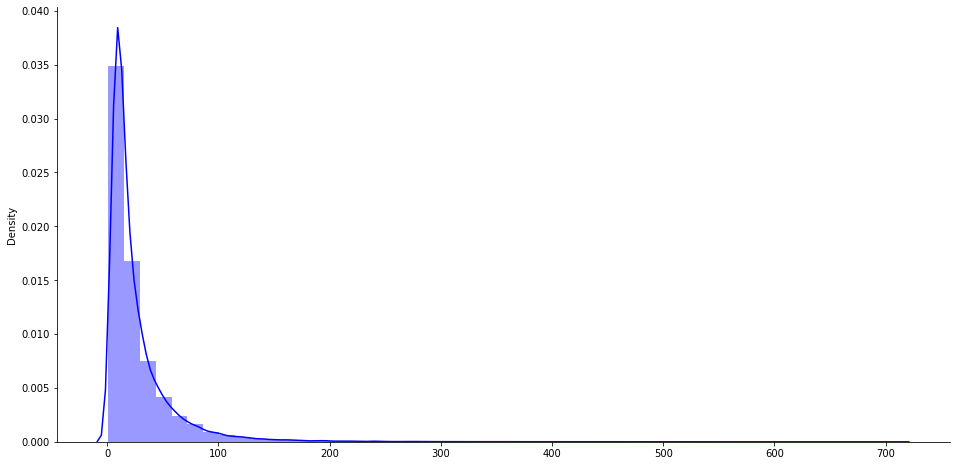

In [ ]:
plt.figure(figsize=(16, 8))
sns.distplot(song_user.values, color='blue')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [ ]:
#ortalama kaç şarkı dinlenmiş ona bakıyoruz.
print(f"Bir şarkı,ortalama  {np.mean(song_user)} kullanıcı, minimum {np.min(song_user)} maksimum {np.max(song_user)} kullanıcı tarafından dinlenmiştir.")

Bir şarkı,ortalama  26.194124657839247 kullanıcı, minimum 1 maksimum 711 kullanıcı tarafından dinlenmiştir.


In [ ]:
# Her kullanıcının kaç şarkı dinlediğini öğreniyoruz.
user_counts = df_all_file.groupby('user_id')['song_id'].count()

# En az 16 şarkı dinlemiş kullanıcıları filtreliyoruz.
user_ten_id = user_counts[user_counts > 16].index.to_list()

In [ ]:
#Her şarkıyı kaç kullanıcının dinlediğini öğreniyoruz.
song_counts = df_all_file.groupby('song_id')['user_id'].count()

# En az 200 kez dinlenen şarkıları edinin
song_ten_id = song_counts[song_counts > 200].index.to_list()

In [ ]:
#yalnızca 16 dan fazla dinlenen kullanıcıları almak için filtreledik.
df_song_reduced = df_all_file[(df_all_file['user_id'].isin(user_ten_id)) & (df_all_file['song_id'].isin(song_ten_id))].reset_index(drop=True)

In [ ]:
df_song_reduced.shape

(950353, 7)

In [ ]:
#En popüler şarkılardan listeliyoruz.
populer_songs = df_all_file.groupby('title')['listen_count'].count().reset_index().sort_values(['listen_count', 'title'], ascending = [0,1])
populer_songs['percentage']  = round(populer_songs['listen_count'].div(populer_songs['listen_count'].sum())*100, 2)

In [ ]:
#10 tane popüler şarkıyı listeliyoruz.
populer_songs = populer_songs[:10]
populer_songs

,title,listen_count,percentage
6836,Sehr kosmisch,8277,0.410
8725,Undo,7032,0.350
1964,Dog Days Are Over (Radio Edit),6949,0.350
9496,You're The One,6729,0.340
6498,Revelry,6145,0.310
6825,Secrets,5841,0.290
3437,Horn Concerto No. 4 in E flat K495: II. Romanc...,5385,0.270
2595,Fireflies,4795,0.240
3322,Hey_ Soul Sister,4758,0.240
8494,Tive Sim,4548,0.230


In [ ]:
labels = populer_songs['title'].tolist()
counts = populer_songs['listen_count'].tolist()

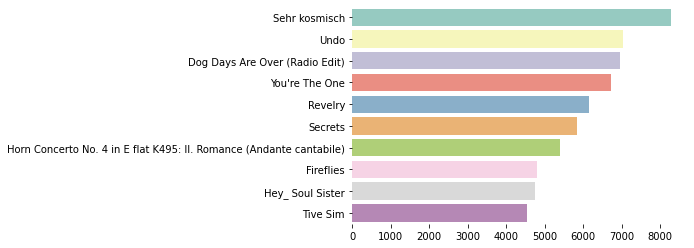

In [ ]:
#En popüler şarkıları görselleştiriyoruz.
plt.figure()
sns.barplot(x=counts, y=labels, palette='Set3')
sns.despine(left=True, bottom=True)

In [ ]:
#En popüler artistleri listeliyoruz.
populer_artists  = df_all_file.groupby(['artist_name'])['listen_count'].count().reset_index().sort_values(['listen_count', 'artist_name'], 
                                                                                                ascending = [0,1])

In [ ]:
#10 tane en popüler artisti listeliyoruz.
populer_artists = populer_artists[:10]
populer_artists

,artist_name,listen_count
649,Coldplay,29422
2850,The Black Keys,19862
1651,Kings Of Leon,18747
1107,Florence + The Machine,18112
1370,Jack Johnson,17801
2946,The Killers,16063
2374,Radiohead,14890
736,Daft Punk,14715
2073,Muse,14005
1554,Justin Bieber,13959


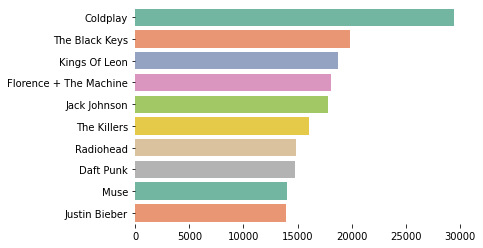

In [ ]:
#10 popüler artisti görselleştiriyoruz.
plt.figure()
labels = populer_artists['artist_name'].tolist()
counts = populer_artists['listen_count'].tolist()
sns.barplot(x=counts, y=labels, palette='Set2')
sns.despine(left=True, bottom=True)

In [ ]:
#benzer kullanıcının benzer şarkıyı dinlediği süre ne kadardır bakıyoruz.
listen_counts = pd.DataFrame(df_all_file.groupby('listen_count').size(), columns=['count'])

In [ ]:
print(f"Aynı kullanıcının aynı şarkıları dinlediği maksimum süre: {listen_counts.reset_index(drop=False)['listen_count'].iloc[-1]}")

Aynı kullanıcının aynı şarkıları dinlediği maksimum süre: 2213


In [ ]:
print(f"Ortalama olarak, bir kullanıcı aynı şarkıyı {df_all_file['listen_count'].mean()} kez dinler.")

Ortalama olarak, bir kullanıcı aynı şarkıyı 3.0454845 kez dinler.


In [ ]:
#Bir kullanıcının aynı şarkıyı ne kadar sık dinlediğinin sayısına bakıyoruz.
listen_counts_continuity = listen_counts[listen_counts['count'] > 50].reset_index(drop=False)

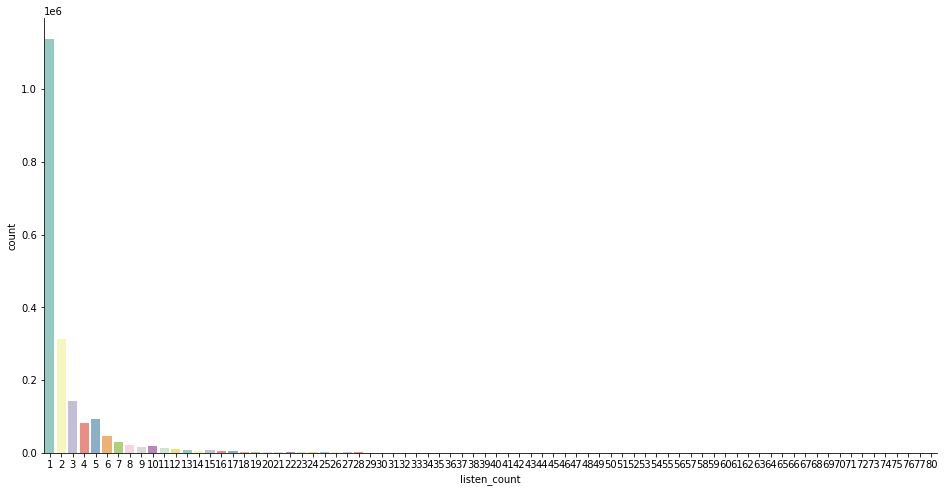

In [ ]:
plt.figure(figsize=(16, 8))
sns.barplot(x='listen_count', y='count', palette='Set3', data=listen_counts_continuity)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [ ]:
#Bir kullanıcı ortalama kaç şarkı dinliyora bakıyoruz.
song_user = df_all_file.groupby('user_id')['song_id'].count()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


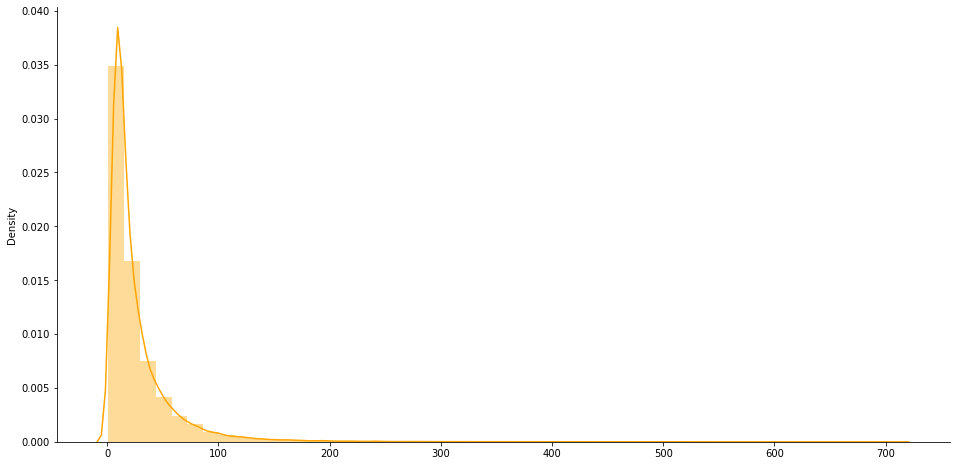

In [ ]:
plt.figure(figsize=(16, 8))
sns.distplot(song_user.values, color='orange')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();


In [ ]:
#Bir kullanıcının ortalama 27 şarkı dinlediğini görüyoruz.
print(f"Bir kullanıcı ortalama {np.mean(song_user)} şarkı dinler.")

Bir kullanıcı ortalama 26.194124657839247 şarkı dinler.


In [ ]:
#Bir kullanıcının dinlediği maksimum şarkı miktarı bile 711'dir.
print(f"Bir kullanıcı ortalama {np.median(song_user)} şarkı, minumum {np.min(song_user)} and maksimum {np.max(song_user)} şarkı dinlemiştir.")

Bir kullanıcı ortalama 16.0 şarkı, minumum 1 and maksimum 711 şarkı dinlemiştir.


In [ ]:
# Sparse matrixleri kontrol edicez. Tüm şarkılar tüm kullanıcılar tarafından dinlendiyse kaç değer olması gerektiğine bakıyoruz.
values_matrix = unique_users * unique_songs

In [ ]:
# df_all_file'un gerçek halinden values_matrix'i çıkarıyoruz.
zero_values_matrix = values_matrix - df_all_file.shape[0]

In [ ]:
#herkesin şarkıları dinlemediği ortada ve seyrek veriler elimizde baya var.
print(f"The matrix of users x songs has {zero_values_matrix} values that are zero")

The matrix of users x songs has 728469151 values that are zero


In [ ]:
# En az 16 şarkı dinlemiş kullanıcılar alıyoruz.
song_ten_id = song_user[song_user > 16].index.to_list()

In [ ]:
# yalnızca 16'dan fazla dinlenen kullanıcıları tutmak için filteliyoruz.
df_song_id_more_ten = df_all_file[df_all_file['user_id'].isin(song_ten_id)].reset_index(drop=True)

In [ ]:
# veri çerçevesini bir pivot tabloya dönüştürüyoruz.
df_all_file_features = df_song_id_more_ten.pivot(index='song_id', columns='user_id', values='listen_count').fillna(0)
#seyrek matrisle çalıştığımız için scipy.sparse'deki csr_matrix işlevini kullanıyoruz.
# seyrek matrisi elde ettik.
mat_songs_features = csr_matrix(df_all_file_features.values)

In [ ]:
#Gördüğümüz gibi değerlerin çoğu sıfıra eşittir. Bu, kullanıcının o şarkıyı dinlemediğini gösterir.
df_all_file_features.head()

user_id,000e2c2a8c7870ff9121f212b35c8b3a20cc0e67,000ebc858861aca26bac9b49f650ed424cf882fc,000ef25cc955ad5841c915d269432eea41f4a1a5,0012bf75d43a724f62dc746d9e85ae0088a3a1d6,001322829b5dc3edc59bf78189617ddd8f23c82a,00185e316f07f0f00c325ca034be59c15b362401,0019740e3e8c24e223a6f88e3faa7c144ec5a014,001b005fe5e80d3cb45f320f5658fc8e2e72794e,001f22c638730aed5659034c447d3cf0e658898e,0021d9a4628624f6d70237f9c200ab82e766bf26,002543003041db1d049206b09426d5cdffc0f451,0028292aa536122c1f86fd48a39bd83fe582d27f,00292cf9c6d6e99c5ddbece7e37f957ab1362d25,00296f66ed7fb84c876486aecc9fab2d5809576d,0030822badc23ef6500a72ce7feda1c63faf2262,0031572620fa7f18487d3ea22935eb28410ecc4c,003412e33eb3d05573f7811c1ba61d6a15be5690,00342a0cdf56a45465f09a39040a5bc25b7d0046,00388e5764c59488ec06a109c88b39f59a2b6361,0039bd8483d578997718cdc0bf6c7c88b679f488,003ac50a4e6ed0c9085fecb7a1738730e7ea4942,003bfb50126f91f6389aaee733f5b3e0a8d5cbe0,003d0f3aac94fd261bb74c0124a90750579972d4,003d21762b29fe2ffe20fb9a51eb1e02ebeb3242,003d6d799d58e1fce362f5f4f6c7bcc26c8f3546,003e3919f41dbb8ff05a75623d205f6abcede4fc,003f1064ed75d1156352cd89b25fb752bcc10b13,003f1e939952a57d1a5bc990727acad5ceea97b4,00409f6a83c2bf4299ab6ae2dea958050537b5a9,0041925615557845642a7b1257fdc6229fe1ee5d,00454c72c0b4b99f9cc81ba0b1989597a43669d6,0045c60d98ced5efb3cbf1e0b4b7de1da3f1a506,00488ec44caa0d2fa669780f8cb604bf39e94392,004c7be9336ca88824e1e0b09ef9a2168200fa33,004dc9f93f5ad4a75f9a3ba0da5dd887b31d6bd2,004f6065fa9840913f62e52d94d9c29ea1d26fe1,004fcdf8829d68f4e45ef846ad9f308c4493ed8e,0051a2e7b452e3dc67f48688442032df557897f4,00544d8bde0d7985e8d703c1eb676d41cad33c67,00546de8971645143eead323561d0298d5b0f2be,...,ffb63da2222280f299a7a896edea073728aab343,ffb7096f3eeee706825b4a8c3fab98ce0e0b4216,ffb8299fcb3f31716c93fb8a77dee0d1dbb210f9,ffba3563fd590a51dabc1dfcb8a27119e6035241,ffbc58b89c81227a08ee05d90259bdd9172b9479,ffbe437f18c3bea5c78596c5f3183ee62d440b6c,ffc2563e7dd136bf371371cd21f0cc404a1d7499,ffc564b85d81f0ea427cee3eea2415cc2fc5c4be,ffc5b3bd0575330eb8c4ae4f3b9cabd3ba315dbb,ffc66b4520671da6b2a67a0326201565160d9650,ffc9966885909a0b42493b2558be9dc451317488,ffcc2cff250ea22471df09e76f59e2be0debae72,ffcfb0b34a47fdf55b3d96c1799cd196677f8261,ffd1d617221f5bf00de80ee3eb5d2a17fc8d077d,ffd25d7da8b4e54ea2cde25dd3b52d0e0aef7a5d,ffd458f903d49854685cf4540245c1d297e8bafa,ffd6f34b343cee62cd7dbbf20fb1ab1119b299e5,ffda2736b2204ece3b19e941caacad4106d00ed5,ffdaab327f2fc6b9fa01a4e3e7f41fdd0e468046,ffdb5557e4e24da051ebd6b45ec18c524c55dc40,ffdbaeb5cf2081eb34053a655c20f57524de11ba,ffde97c0d23bf5ce249ce73e630ccb4e7293cc32,ffe2a7e7b6689071f8c699d944b52ce590ae4636,ffe33dce4e652a4dc4824cc39680a9f709cfdfb3,ffebfec313fd515a11faba060b022f030b57fac0,ffecbb84f3dde31b0b2e64d70b7b7e5092bf7427,ffef9c3e59ab44554a9775af5e3b2ac149111bb6,fff03efd1550136063389fa71125194614e1c68f,fff0b1ab076f0b71cbde9c7dcbcfca400708d845,fff22417a61c1ba3ee2592b22a052ed6a27a8e91,fff300cd094fe04030b79fae550dc9d065190182,fff4676dacb2e9a7217702f62ee70e88aa512ecc,fff4e1a7dacbe9c13051c08f09bf66d76cbee35e,fff543db7918cb8f4f56f7470903eb2f1d5a6dd8,fff6c30c773e6ffafcac213c9afd9666afaf6d63,fffb701ee87a32eff67eb040ed59146121f01571,fffc0df75a48d823ad5abfaf2a1ee61eb1e3302c,fffce9c1537fbc350ea68823d956eaa8f5236dbe,fffd9635b33f412de8ed02e44e6564e3644cf3c6,fffea3d509760c984e7d40789804c0e5e289cc86
song_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SOAAAGQ12A8C1420C8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
SOAACPJ12A81C21360,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0

In [ ]:
#Duplicated verilerden kurtuluyoruz.
df_unique_songs = df_all_file.drop_duplicates(subset=['song_id']).reset_index(drop=True)[['song_id', 'title']]

In [ ]:
#Veriler song_id ile geldiği için isimlerini getiriyoruz.
decode_id_song = {
    song: i for i, song in 
    enumerate(list(df_unique_songs.set_index('song_id').loc[df_all_file_features.index].title))
}

In [ ]:
#pip install -r requirements.txt

In [ ]:
#Recommender isminde sınıf oluşturuyoruz. Bu sınıf yeni öneri oluşturmak için oluşturuldu.
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
import numpy as np

class Recommender:
    def __init__(self, metric, algorithm, k, data, decode_id_song):
        self.metric = metric
        self.algorithm = algorithm
        self.k = k
        self.data = data
        self.decode_id_song = decode_id_song
        self.data = data
        self.model = self._recommender().fit(data)
    
    def make_recommendation(self, new_song, n_recommendations):
        recommended = self._recommend(new_song=new_song, n_recommendations=n_recommendations)
        print("... Tamamlandı")
        return recommended 
    
    def _recommender(self):
        return NearestNeighbors(metric=self.metric, algorithm=self.algorithm, n_neighbors=self.k, n_jobs=-1)
    
    def _recommend(self, new_song, n_recommendations):
        # Önerilen şarkıların kimliğini alın.
        recommendations = []
        recommendation_ids = self._get_recommendations(new_song=new_song, n_recommendations=n_recommendations)
        # bir eşleme sözlüğü kullanarak şarkının adını döndürür.
        recommendations_map = self._map_indeces_to_song_title(recommendation_ids)
        # Bu önerileri, önerilen şarkı adlarının sıralamasına çevirin.
        for i, (idx, dist) in enumerate(recommendation_ids):
            recommendations.append(recommendations_map[idx])
        return recommendations
                 
    def _get_recommendations(self, new_song, n_recommendations):
        # Metne göre şarkının kimliğini alın.
        recom_song_id = self._fuzzy_matching(song=new_song)
        # Öneri süreci başlar.
        print(f"  {new_song} için öneri süreci başladı ...")
        # Şarkı kimliği için n komşuyu döndürür.
        distances, indices = self.model.kneighbors(self.data[recom_song_id], n_neighbors=n_recommendations+1)
        return sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    
    def _map_indeces_to_song_title(self, recommendation_ids):
        return {song_id: song_title for song_title, song_id in self.decode_id_song.items()}
    
    def _fuzzy_matching(self, song):
      #eşleme işlemi.
        match_tuple = []
        for title, idx in self.decode_id_song.items():
            str = "title" and "song"
            ratio = fuzz.ratio(str.lower(), str.lower())
            if ratio >= 60:
                match_tuple.append((title, idx, ratio))
        # sıralama işlemi.
        match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
        if not match_tuple:
            print(f"{song} Öneri sistemi için bir eşleşme bulamadı")
            return
        return match_tuple[0][1]

In [ ]:
#Recommender sınıfını şarkıları tahmin etmek için kullanıyoruz.
model = Recommender(metric='cosine', algorithm='brute', k=20, data=mat_songs_features, decode_id_song=decode_id_song)

In [ ]:
#Şarkı ismini yazıyoruz.
song = 'I believe in miracles'

In [ ]:
#10 tane öneride bulunulacak.
new_recommendations = model.make_recommendation(new_song=song, n_recommendations=10)

  I believe in miracles için öneri süreci başladı ...
... Tamamlandı


In [ ]:
#Yeni önerleri yazdırıyoruz.
print(f" {song} için öneriler :")
print(f"\n{new_recommendations}\n\n")

 I believe in miracles için öneriler :

['Paradise Circus (Gui Boratto Remix)', 'End Credits', 'Land of Hope and Dreams', 'Miami', 'Yeah', 'Smoke Some Weed (edited version)', 'Unravel', 'Possibly Maybe', 'Reclaimer', 'Pieces']




Matris Çarpanlara ayırma, bir öneri sistemini oluşturmanın güçlü bir yoludur. Bunun arkasındaki fikir, kullanıcıları ve öğeleri daha düşük boyutlu bir gizli uzayda temsil etmektir.
Başka bir deyişle, Matris çarpanlarına ayırma yöntemleri, orijinal seyrek kullanıcı öğesi matrisini, gizli özelliklere sahip daha düşük boyutlu daha az seyrek dikdörtgen matrislere ayrıştırır.
Bu, yalnızca seyreklik sorununu çözmekle kalmaz, aynı zamanda yöntemi ölçeklenebilir hale getirir.
Burada matrix ayrıştırma yöntemi olan SVD'yi uygulayacağız.

U, kullanıcı-user matrix.
V, şarkı-song matrix.
S, orijinal matrisin tekil değerlerini içeren köşegen matristir.

In [ ]:
#Burada binning işlemi yapıyoruz. Bu işlem numerik verilerin kategorik karşılıklarına dönüştürülmesi işlemine verilen addır.
#Örneğin Age değişkeninin değerlerini 20-39, 40-59 ve 60-79 gibi aralıklara gruplama işlemi buna bir örnek olarak verilebilir.
#bu yöntem aykırı gözlemlerin tespitini, geçersiz veya eksik numerik değerlerin tespitini kolaylaştırır.
#10 kategori tanımlıyoruz. 0'dan 1'e kadar olan aralığa düşen orijinal veri değerleri, temsili 1 derecelendirmesi ile değiştirilecektir.
#Son kategori, 9 ile 2213 arasında değişen orijinal değerlere atanacaktır.
#Bir kullanıcı bir şarkıyı 10 defadan fazla dinlerse, 10 atayacağız.
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2214]

In [ ]:
df_song_reduced['listen_count'] = pd.cut(df_song_reduced['listen_count'], bins=bins, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [ ]:
listen_counts = pd.DataFrame(df_song_reduced.groupby('listen_count').size(), columns=['count']).reset_index(drop=False)

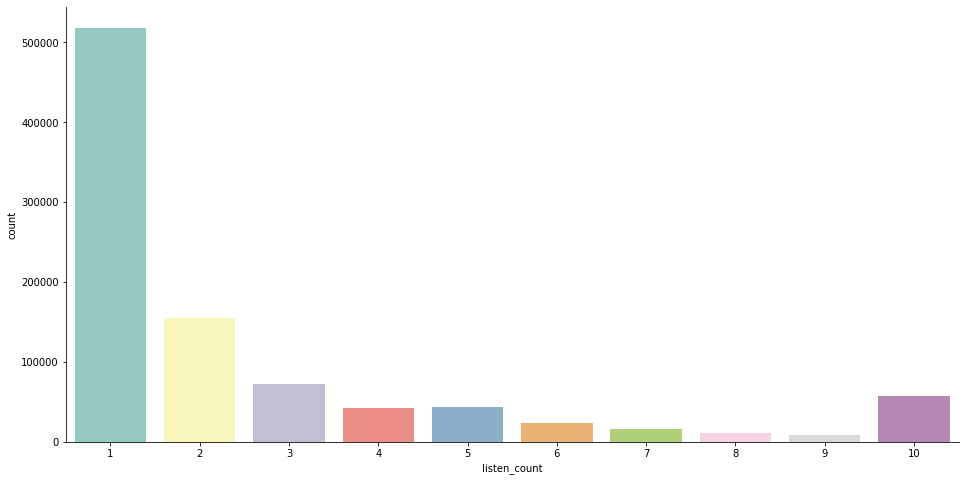

In [ ]:
#oluşturduğumuz 10 kategoriyi görselleştiriyoruz.
plt.figure(figsize=(16, 8))
sns.barplot(x='listen_count', y='count', palette='Set3', data=listen_counts)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [ ]:
#Surprise, özellikle tavsiye sistemleri için tasarlanmış, kullanımı kolay bir Python kütüphanesidir. burdada kullanacağız.
#Dosyamızdan derecelendirmeleri içeren dataframe'i çekiyoruz.
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df_song_reduced[['user_id', 'song_id', 'listen_count']], reader)

In [ ]:
#verimizi test ve eğitim olarak ikiye ayırdık.
trainset, testset = train_test_split(data, test_size=.25)

In [ ]:
#en iyi parametreleri bulmak için birden fazla parametre  tanımlıyoruz.
param_grid = {'n_factors': [160], 
              'n_epochs': [100], 
              'lr_all': [0.001, 0.005],
              'reg_all': [0.08, 0.1]}

Buradaki SVD bir matrisi diğer iki matriste çarpanlarına ayırdığını ve ardından özelliklerin ve ağırlıkların en uygun değerlerini bulmak için gradyan inişini kullanan yöntemdir.

In [ ]:
#GridSearchCV sınıfı, cross-validation yaparak SVDalgorithm  için doğrululuk ölçümlerini hesaplayacak.
grid_search_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, joblib_verbose=4, n_jobs=-2)

In [ ]:
# model için en iyi parametreleri buluyor.
grid_search_svd.fit(data)
find_algo = grid_search_svd.best_estimator['rmse']
print(grid_search_svd.best_score['rmse'])
print(grid_search_svd.best_params['rmse'])

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:  4.7min remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:  9.4min remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   3 out of   3 | elapsed: 14.1min remaining:    0.0s


2.196653880110077
{'n_factors': 160, 'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.1}


[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed: 56.3min finished


In [ ]:
# cross validation işlemi yapılıyor..
cross_validate(find_algo, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.1786  2.1811  2.1722  2.1713  2.1785  2.1764  0.0039  
Fit time          330.43  334.23  332.56  334.51  333.48  333.04  1.47    
Test time         3.85    3.20    3.62    3.60    3.52    3.56    0.21    


{'fit_time': (330.42696356773376,
  334.23361563682556,
  332.56328535079956,
  334.5083963871002,
  333.4791622161865),
 'test_rmse': array([2.17864239, 2.18109633, 2.17221136, 2.17132086, 2.17854837]),
 'test_time': (3.8483097553253174,
  3.198702096939087,
  3.6153924465179443,
  3.5999739170074463,
  3.523448944091797)}

In [ ]:
#Model için en iyi parametreleri bulduktan sonra son modelimizi oluşturuyor, eğitiyor ve test seti için hatayı buluyoruz.
final_algorithm = SVD(n_factors=160, n_epochs=100, lr_all=0.005, reg_all=0.1)
final_algorithm.fit(trainset)
test_predictions = final_algorithm.test(testset)
#accuracy'i hesaplanıyor.
print(f"The RMSE is {accuracy.rmse(test_predictions, verbose=True)}")

RMSE: 2.1846
The RMSE is 2.184638130030212


In [ ]:
#Artık bir kullanıcının belirli bir şarkıya vereceği puanı bulabiliriz.
# bir şarkı seçiliyor.
song = df_song_reduced['title'].iloc[100]
# bir kullanıcı seçiliyor.
user = df_song_reduced['user_id'].iloc[5]

# tahminde bulunuluyor.
prediction = final_algorithm.predict(5, 100)

print(f" {user} kullanıcısının {song} şarkısına vereceği derecelendirmesi {round(prediction.est, 2)}")

 b80344d063b5ccb3212f76538f3d9e43d87dca9e kullanıcısının Sleeping In (Album) şarkısına vereceği derecelendirmesi 2.57
